In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
np.set_printoptions(precision=2)

## Kernelized Regression

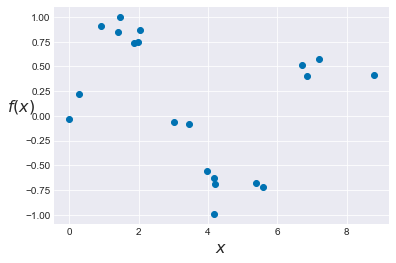

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_01.png', dpi=300, figsize=[5.5, 5.5])

In [3]:
def gauss_kernel(x, n_knots):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(x.min(), x.max(), n_knots)    
    w = 2 
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

In [4]:
n_knots = 5

In [5]:
with pm.Model() as kernel_model:
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd',0,  10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    #kernel_trace = pm.sample(10000, step=pm.Metropolis())
    kernel_trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:19<00:00, 544.19it/s]


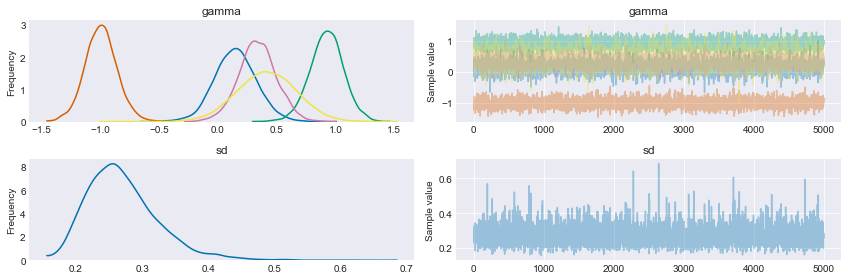

In [6]:
chain = kernel_trace[5000:]
pm.traceplot(chain);
plt.savefig('B04958_08_02.png', dpi=300, figsize=[5.5, 5.5])

In [7]:
pm.df_summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
gamma__0,0.150193,0.179561,0.002300,-0.183726,0.522379
gamma__1,0.923430,0.142992,0.002103,0.646014,1.214635
gamma__2,-0.996414,0.135967,0.002018,-1.258063,-0.712942
gamma__3,0.338413,0.161199,0.002467,0.016626,0.655868
gamma__4,0.414947,0.255175,0.003670,-0.089042,0.903086
sd,0.270132,0.054679,0.000942,0.177981,0.377855


100%|██████████| 100/100 [00:00<00:00, 207.92it/s]


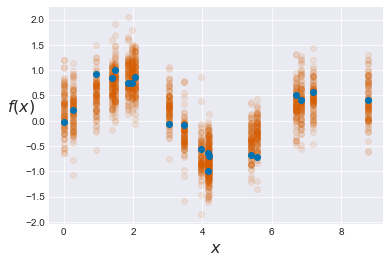

In [8]:
ppc = pm.sample_ppc(chain, model=kernel_model, samples=100)

plt.plot(x, ppc['yl'].T, 'C2o', alpha=0.1)

plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_03.png', dpi=300, figsize=[5.5, 5.5])

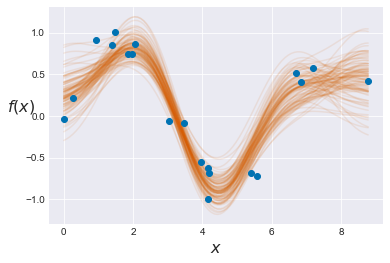

In [9]:
new_x = np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = chain['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'C2-', alpha=0.1)
plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_04.png', dpi=300, figsize=[5.5, 5.5])

## Gaussian Processes

In [10]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

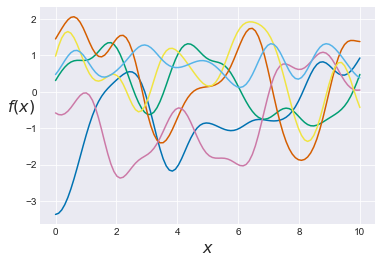

In [11]:
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_05.png', dpi=300, figsize=[5.5, 5.5]);

/home/osvaldo/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


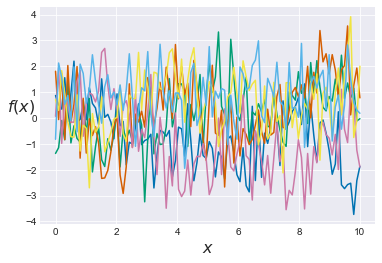

In [12]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03
D = squared_distance(test_points, test_points)

cov = eta * np.exp(-rho * D)
diag = eta * sigma

np.fill_diagonal(cov, diag)

for i in range(6):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_06.png', dpi=300, figsize=[5.5, 5.5]);

/home/osvaldo/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


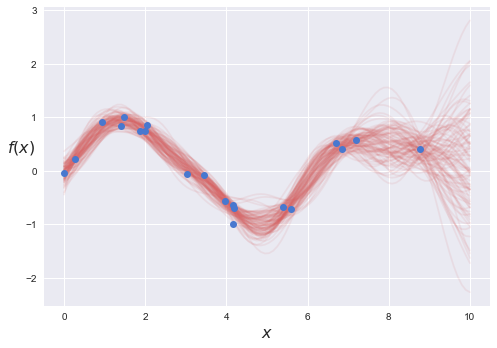

In [13]:
np.random.seed(1)

K_oo = eta * np.exp(-rho * D) 

D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

# Posterior mean
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)
# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)


for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)

plt.plot(x, y, 'o')
 
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_07.png', dpi=300, figsize=[5.5, 5.5]);

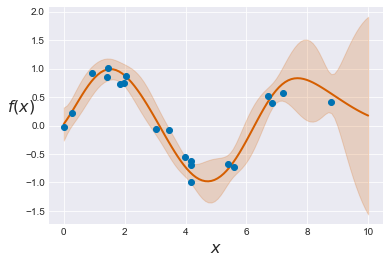

In [14]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(x).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return eta * np.exp(- rho * sqdist)

N = 20         # number of training points.
n = 100         # number of test points.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(0, 10, size=(N,1))
yfx = f(X) + sigma * np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(0, 10, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, yfx))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5


plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu + 2 * sd_pred, color="C2", alpha=0.2)
plt.plot(Xtest, mu, 'C2', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_08.png', dpi=300, figsize=[5.5, 5.5]);

In [15]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    D = squared_distance(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    #start = pm.find_MAP()
    #trace = pm.sample(1000, start=start)
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:19<00:00, 102.18it/s]


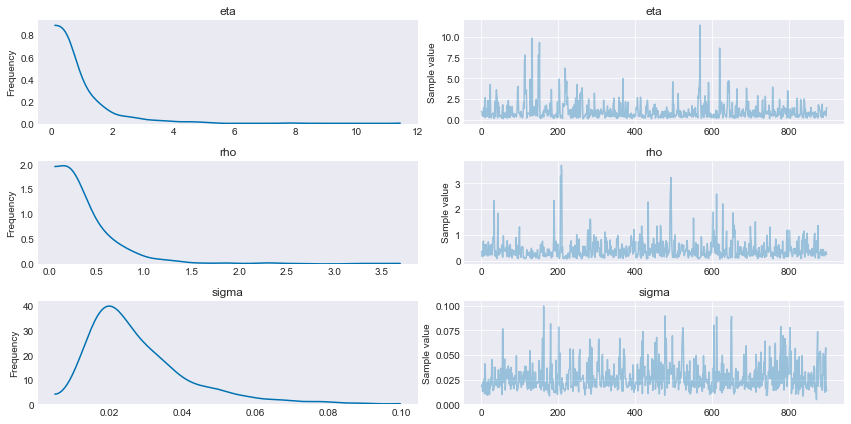

In [16]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames)
plt.savefig('B04958_08_09.png', dpi=300, figsize=[5.5, 5.5]);

In [17]:
pm.df_summary(chain, varnames).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
eta,1.0368,1.1672,0.0607,0.0989,3.1892
rho,0.4251,0.3983,0.0177,0.0586,1.0675
sigma,0.0280,0.0140,0.0006,0.0084,0.0564


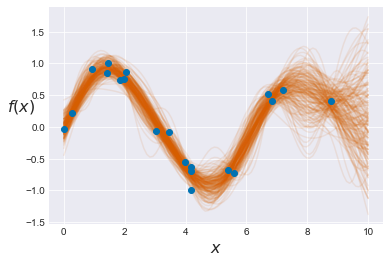

In [19]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'C2-', alpha=0.1)

plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_10.png', dpi=300, figsize=[5.5, 5.5]);

# Periodic Kernel

In [21]:
periodic = lambda x, y: np.array([[np.sin((x[i] - y[j])/2)**2 for i in range(len(x))] for j in range(len(y))])

In [22]:
with pm.Model() as GP_periodic:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    P = periodic(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * P), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = periodic(test_points, test_points)
    D_off_diag = periodic(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    #start = pm.find_MAP()
    #trace = pm.sample(1000, start=start)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:15<00:00, 99.41it/s] 


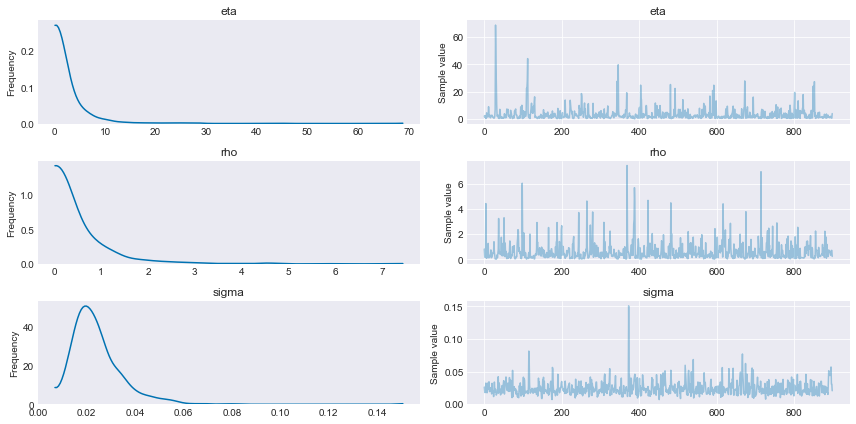

In [23]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames);

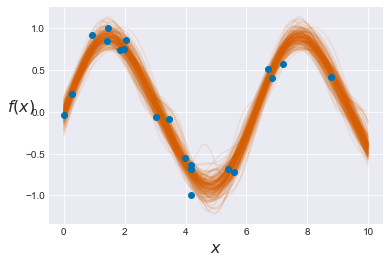

In [24]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'C2-', alpha=0.1)

plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_11.png', dpi=300, figsize=[5.5, 5.5]);

In [25]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nPandas %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, pd.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a computer x86_64 running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.1
SciPy 0.19.1
Pandas 0.20.3
Matplotlib 2.0.2
Seaborn 0.8.0

